
# **Segmentation des IRM Cérébrales avec U-Net et Distillation de Connaissances**  
---

**Projet réalisé par :**  
 *Elhaj EBOU*  

la **preparation** de la dataset

In [ ]:
!pip install h5py

In [2]:
from google.colab import drive
import os

# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# **Définition du Dataset et Prétraitement des Données**
---

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import os
import torch.nn.functional as F


class BraTSDataset(Dataset):
    def __init__(self, file_paths, data_dir):
        self.file_paths = file_paths
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_paths[idx])

        with h5py.File(file_path, "r") as f:
            image = np.array(f["image"], dtype=np.float32)  # (240, 240, 4)
            mask = np.array(f["mask"], dtype=np.uint8)  # (240, 240, 3) ou (240, 240)

        # Assurer que l'image est bien en (C, H, W)
        image = np.moveaxis(image, -1, 0)  # (H, W, C) -> (C, H, W)

        # Si le masque est one-hot avec 3 canaux, convertir en classes
        if mask.ndim == 3 and mask.shape[-1] == 3:
            mask = np.argmax(mask, axis=-1)  # (H, W, 3) -> (H, W)

        # Normalisation de l’image (0 à 1)
        if np.max(image) > np.min(image):
            image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
        else:
            image = np.zeros_like(image)

        # Convertir en tenseurs PyTorch
        image = torch.tensor(image, dtype=torch.float32)  # (4, 240, 240)
        mask = torch.tensor(mask, dtype=torch.long)  # (240, 240)

        # Redimensionner à (256, 256)
        image = F.interpolate(image.unsqueeze(0), size=(256, 256), mode="bilinear", align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(256, 256), mode="nearest").squeeze(0).squeeze(0).long()

        return image, mask


# Chemin des fichiers `.h5`
data_dir = "/content/drive/MyDrive/Eby/tumor_segmentation/BraTS2020_training_data/content/data"

all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".h5")])
file_paths = all_files[:10000]

# Définition des proportions pour train et validation
train_size = int(0.8 * len(file_paths))
valid_size = len(file_paths) - train_size

# Split des fichiers
train_files = file_paths[:train_size]
valid_files = file_paths[train_size:]

# Création des datasets et DataLoaders
train_dataset = BraTSDataset(train_files, data_dir)
valid_dataset = BraTSDataset(valid_files, data_dir)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)


# **Les modalites disponibles dans le dataset Brat2020**

 Clés disponibles dans le fichier HDF5 : ['image', 'mask']
 Taille de l'image : (240, 240, 4)
 Taille du masque : (240, 240, 3)
 Image - Min: -0.4143970639208053 Max: 7.892163651379495 Moyenne: -1.0880185641326534e-16
 Masque - Unique values: [0 1]


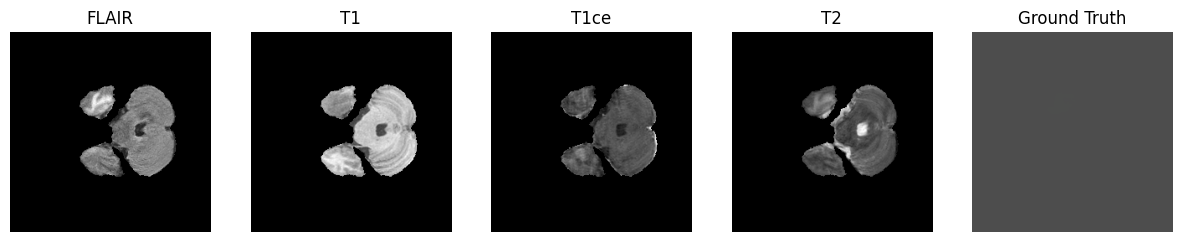

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/Eby/tumor_segmentation/BraTS2020_training_data/content/data/volume_1_slice_39.h5"

with h5py.File(file_path, "r") as f:
    print(" Clés disponibles dans le fichier HDF5 :", list(f.keys()))

    # Chargement de l’image et du masque
    image = np.array(f["image"])
    mask = np.array(f["mask"])

    # Affichage des statistiques de l’image
    print(" Taille de l'image :", image.shape)
    print(" Taille du masque :", mask.shape)
    print(" Image - Min:", image.min(), "Max:", image.max(), "Moyenne:", image.mean())
    print(" Masque - Unique values:", np.unique(mask))  # Vérification des classes du masque

#  Affichage des modalités IRM et du masque
modalities = ["FLAIR", "T1", "T1ce", "T2"]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Affichage des 4 modalités IRM
for i in range(4):
    axes[i].imshow(image[:, :, i], cmap="gray")
    axes[i].set_title(modalities[i])
    axes[i].axis("off")

axes[4].imshow(mask, cmap="hot", alpha=0.7)
axes[4].set_title("Ground Truth")
axes[4].axis("off")

plt.show()


# **La Définition des Modèles**


L'architecture des modèles Teacher et Étudiant


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super(UNet, self).__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final_conv(d1)

class UNetStudent(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super(UNetStudent, self).__init__()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = DoubleConv(128, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final_conv(d1)


# Initialisation des modèles Teacher et Student
teacher_model = UNet().to(device)


student_model = UNetStudent().to(device)


# Definition des **loss** et du **score** functions

In [4]:
import torch.optim as optim

def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.softmax(preds, dim=1)
    targets_onehot = F.one_hot(targets, num_classes=4).permute(0, 3, 1, 2)

    intersection = (preds * targets_onehot).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets_onehot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice.mean()



def dice_score(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)  # Convertir en classes prédictes (batch, H, W)
    preds_onehot = F.one_hot(preds, num_classes=4).permute(0, 3, 1, 2)  # (batch, classes, H, W)
    targets_onehot = F.one_hot(targets, num_classes=4).permute(0, 3, 1, 2)  # (batch, classes, H, W)

    intersection = (preds_onehot * targets_onehot).sum(dim=(2, 3))  # Somme des pixels communs
    union = preds_onehot.sum(dim=(2, 3)) + targets_onehot.sum(dim=(2, 3))  # Somme totale

    dice = (2. * intersection + smooth) / (union + smooth)  # Formule du Dice Score
    return dice.mean()

    # Définition de la distillation loss (Kullback-Leibler Divergence)
def distillation_loss(student_preds, teacher_preds, temperature=2):
    """
    Calcule la perte de distillation entre les prédictions du modèle Student et celles du modèle Teacher.
    """
    student_soft = F.log_softmax(student_preds / temperature, dim=1)
    teacher_soft = F.softmax(teacher_preds / temperature, dim=1)

    return F.kl_div(student_soft, teacher_soft, reduction="batchmean") * (temperature ** 2)

# Définition de la loss totale (Distillation + Dice Loss)
def total_loss(student_preds, teacher_preds, true_masks, alpha=0.5):
    """
    Combine la distillation loss et la dice loss.
    """
    loss_dice = dice_loss(student_preds, true_masks)  # Dice Loss
    loss_distill = distillation_loss(student_preds, teacher_preds)  # KL Divergence

    return alpha * loss_distill + (1 - alpha) * loss_dice

88


# L'entrainement des models **Teacher** et **Student**

In [ ]:

def evaluate_model(model, valid_loader):
    model.to(device)
    model.eval()

    valid_loss = []
    valid_dice = []

    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = dice_loss(outputs, masks)

            dice = dice_score(outputs, masks)
            valid_dice.append(dice.item())

            valid_loss.append(loss.item())

    print(f"Validation Loss: {np.mean(valid_loss):.4f} | Validation Dice Score: {np.mean(valid_dice):.4f}")





def train_student(student_model, teacher_model, train_loader, valid_loader, optimizer, num_epochs=10):
    student_model.train()
    teacher_model.eval()

    for epoch in range(num_epochs):
        train_loss = []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # Prédictions du modèle Student
            student_preds = student_model(images)

            # Prédictions du modèle Teacher (pas de gradient)
            with torch.no_grad():
                teacher_preds = teacher_model(images)

            # Calcul de la perte
            loss = total_loss(student_preds, teacher_preds, masks)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {np.mean(train_loss):.4f}")

        # Évaluation sur le dataset de validation
        evaluate_model(student_model, valid_loader)

        # Sauvegarde du modèle Student après chaque epoch
        torch.save(student_model.state_dict(), "/content/drive/MyDrive/Eby/tumor_segmentation/best_model_student/unet_student.pth")
        print("Modèle Student sauvegardé.\n")



def train_model(model, train_loader, valid_loader, loss_fn, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        train_dice = []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks).to(device)
            loss.backward()
            optimizer.step()

            dice = dice_score(outputs, masks)
            train_dice.append(dice.item())

            train_loss.append(loss.item())

        avg_train_loss = np.mean(train_loss)
        avg_train_dice = np.mean(train_dice)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Dice Score: {avg_train_dice:.4f}")

        # Évaluer sur le jeu de validation après chaque epoch
        evaluate_model(model, valid_loader)
        torch.save(model.state_dict(), "/content/drive/MyDrive/Eby/tumor_segmentation/best_model_teacher/unet_model.pth")
        print("Modèle Teacher sauvegardé.")

#  Optimiseur pour le modèle Teacher
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=1e-4)


# LEntraînement du modèle Teacher
train_model(teacher_model, train_loader, valid_loader, dice_loss, optimizer_teacher, num_epochs=10)

# Optimiseur pour le modèle Student
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

# Entraînement du modèle Student
train_student(student_model, teacher_model, train_loader, valid_loader, optimizer_student, num_epochs=10)


# **La visualisation des *Prediction* des models sur la validation set**

In [4]:
import random

teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/Eby/tumor_segmentation/best_model_teacher/unet_model.pth", map_location=device))
teacher_model.eval()
student_model.load_state_dict(torch.load("/content/drive/MyDrive/Eby/tumor_segmentation/best_model_student/unet_student4.pth", map_location=device))
student_model.eval()
# Sélectionner 5 indices aléatoires du dataset de validation
indices = random.sample(range(len(valid_dataset)), 5)  # 5 images pour une meilleure lisibilité

# Préparer les images, masques réels et prédits
images_np = []
true_masks_np = []
teacher_masks_np = []
student_masks_np = []

for idx in indices:
    image, true_mask = valid_dataset[idx]

    # Ajouter une dimension batch et envoyer au GPU si disponible
    image = image.unsqueeze(0).to(device)  # (1, 4, 256, 256)
    true_mask = true_mask.to(device)  # (256, 256)

    # Prédiction du modèle Teacher
    with torch.no_grad():
        teacher_pred_mask = teacher_model(image)
        teacher_pred_mask = torch.argmax(teacher_pred_mask, dim=1).squeeze(0)

    # Prédiction du modèle Student
    with torch.no_grad():
        student_pred_mask = student_model(image)
        student_pred_mask = torch.argmax(student_pred_mask, dim=1).squeeze(0)

    # Convertir en numpy pour affichage
    images_np.append(image.squeeze(0).cpu().numpy()[0])  # Prendre le premier canal (FLAIR)
    true_masks_np.append(true_mask.cpu().numpy())
    teacher_masks_np.append(teacher_pred_mask.cpu().numpy())
    student_masks_np.append(student_pred_mask.cpu().numpy())

# Définir la figure pour afficher les images en colonne
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 20))

for i in range(5):
    axes[i, 0].imshow(images_np[i], cmap="gray")
    axes[i, 0].set_title(f"Image {i+1} (FLAIR)")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(true_masks_np[i], cmap="jet")
    axes[i, 1].set_title(f"Masque Réel {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(teacher_masks_np[i], cmap="jet")
    axes[i, 2].set_title(f"Masque Teacher {i+1}")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(student_masks_np[i], cmap="jet")
    axes[i, 3].set_title(f"Masque Student {i+1}")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()